# IFTE0002 Coursework

### Contents
1. Exploratory Data Analysis
2. ANN Model - Default Prediction
3. Comparison of Model Predictions w Random Predictions
4. Implementation of Investment Strategy vs random investment??
5. Analysis

Notes: 
- Assume we are participating in P2P lending (pre-2020 service offered by the lending club). We invest in loans by purchasing 'notes' and earn returns by the returned principal and interest by the borrower.
- Note class imbalance (likely impacts model performance as model does not have enough instances of 'default' to learn from)
- Due to different scale of features, applied standardization

- Data preprocessing, created dummies of categorical variables instead of single numeric column (to avoid implicit ordering)
    - dropped first to avoid multicollinearity / avoid unnecessary redundancy
- dropped loan_status to avoid feature leakage
- dropped dates (high cardinality, not useful) + can be leaky (last payment date for example)
- dropped 'term' - replication of term_num
- dropped 'funded_amnt' as it is exactly the same as loan amnt
- drop 'total payment' - leaky feature, directly related to how much was paid after loan was issues
- drop 'recoveries' - leaky feature, only occurs if loan went bad
- drop return columns - may be calculated after loan matures (leaky)
- convert earliest_cr_line into column of number of months they had credit before opening loan

- Model build
    - use early stopping and reduce lr callbacks to avoid overfitting

Use of GenAI (ChatGPT):
- starter code for creating plots
- starter code for model building / setting up env
- get feature definitions (makeshift data directory)



In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pydantic import BaseModel, Field
from pydantic.config import ConfigDict
from typing import Union, List

In [55]:
# Load dataset
data, discrete_features, continuous_features = pd.read_pickle("lending_club_dataset.pickle")

In [3]:
# get discrete and cont features (lists above are incomplete)
disc = []
cont = []

for col in data.select_dtypes(include=['number', 'object', 'category']).columns:
    unique_vals = data[col].nunique(dropna=True)
    dtype = data[col].dtype

    if pd.api.types.is_numeric_dtype(dtype):
        if unique_vals <= 5:
            disc.append(col)
        else:
            cont.append(col)
    else:
        disc.append(col)

## 1. Exploratory Data Analysis

#### Questions to answer using EDA
- Distrubutions of loan status (proportion defaulted etc.)
- Distributions of loan grades
- Distributions of annual inc / home ownership etc (profile of people borrowing from lending club)
- What is the relationship between loan term (or length?) and default
- Relationship between loan recoveries and int rate, and installment?
- Relationship between loan status and home ownership, annual inc, emp length

In [17]:
data.describe()

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,open_acc,pub_rec,fico_range_high,...,recoveries,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc,binary_target,multiclass_target
count,605374.000000,605374.000000,605374.00000,605374.000000,6.053740e+05,605374.000000,605374.000000,605374.000000,605374.000000,605374.000000,...,605374.000000,605374.000000,605374.000000,605374.000000,605374.000000,605374.000000,605374.000000,605374.000000,605374.000000,605374.000000
mean,14552.362506,14552.362506,12.69876,439.151480,7.687993e+04,18.969691,0.338577,11.846685,0.239870,699.438314,...,254.129004,20.106174,41.682464,0.005759,0.045801,0.012465,0.028547,0.058141,0.000035,0.211407
std,8795.106114,8795.106114,4.77739,262.995589,7.277882e+04,11.783039,0.920335,5.676809,0.641496,31.856039,...,982.899170,11.594011,10.202397,0.082310,0.107628,0.060556,0.064719,0.072475,0.005890,0.408306
min,1000.000000,1000.000000,5.31000,14.010000,1.600000e+01,-1.000000,0.000000,1.000000,0.000000,664.000000,...,0.000000,0.919937,36.000000,-0.333083,-0.333083,-0.199841,-0.199827,-0.199801,0.000000,0.000000
25%,8000.000000,8000.000000,9.17000,248.442500,4.571275e+04,12.190000,0.000000,8.000000,0.000000,674.000000,...,0.000000,10.020740,36.000000,0.009038,0.036616,0.018124,0.037480,0.071395,0.000000,0.000000
50%,12000.000000,12000.000000,12.29000,373.920000,6.500000e+04,18.200000,0.000000,11.000000,0.000000,694.000000,...,0.000000,18.990123,36.000000,0.032468,0.068647,0.031701,0.049552,0.082138,0.000000,0.000000
75%,20000.000000,20000.000000,15.59000,583.890000,9.181350e+04,24.980000,0.000000,15.000000,0.000000,714.000000,...,0.000000,31.047865,36.000000,0.051713,0.105569,0.045422,0.063087,0.095792,0.000000,0.000000
max,40000.000000,40000.000000,30.99000,1719.830000,9.550000e+06,999.000000,39.000000,90.000000,86.000000,850.000000,...,35581.880000,49.939424,60.000000,0.180332,1.628427,0.171967,0.194177,0.234413,1.000000,1.000000


In [25]:
# Set plot styles
sns.set_style("darkgrid")
sns.set_palette("colorblind")  # deep  # pastel

In [112]:
class DataProfile(BaseModel):
    """
    Methods for Exploratory Data Analysis.
    """
    df: pd.DataFrame
    continuous_features: List[str] = Field(default=cont, description="list of discrete features")
    discrete_features: List[str] = Field(default=disc, description="list of continuous features")
    
    model_config = ConfigDict(arbitrary_types_allowed=True)
    
    def plot_distribution(self, feature: str):
        """
        Method for plotting distribution of feature.
        Plots KDE for continuous variables and Histogram for discrete variables.
        """
        plt.figure(figsize=(15,5))
        plt.title(f"Distribution of {feature}")
        
        if feature in self.continuous_features:
            sns.kdeplot(self.df[feature])
            plt.ylabel("Density")
        else:
            ax = sns.histplot(self.df[feature].dropna(), kde=True, bins=30)
            # Add counts
            ax.bar_label(ax.containers[0], fmt='%d', label_type='edge', fontsize=9)
            plt.ylabel("Frequency")

            # labels = [label.get_text() for label in ax.get_xticklabels()]
            # # ax.set_xticks(range(len(labels)))
            # ax.set_xticklabels(sorted(labels))  # alphabetically sorted
        
        plt.show()
    
    def plot_comparative_dist(self, feature1: str, feature2: str, plot_type: str = "kde"):
        if plot_type == "kde":
            if any([feature in self.discrete_features for feature in [feature1, feature2]]):
                return "TypeError: KDE cannot be created using discrete features."
            plt.figure(figsize=(15,5))
            sns.kdeplot(self.df[feature1].dropna(), label=feature1, fill=True, alpha=0.4)
            sns.kdeplot(self.df[feature2].dropna(), label=feature2, alpha=0.4)
    
            plt.title(f'KDE Comparison: {feature1} vs {feature2}')
            plt.xlabel('Value')
            plt.ylabel('Density')
            plt.legend()
            plt.tight_layout()
            plt.show()

        if plot_type == "boxplot":
            plt.figure(figsize=(15,5))
            sns.boxplot(data=self.df[[feature1, feature2]])
            plt.title(f'Boxplot Comparison: {feature1} vs {feature2}')
            plt.tight_layout()
            plt.show()

    def plot_relationship_continuous(self, x: str, y: str):
        plt.figure(figsize=(15, 5))
    
        if pd.api.types.is_numeric_dtype(self.df[x]) and pd.api.types.is_numeric_dtype(self.df[y]):
            sns.scatterplot(data=self.df, x=x, y=y, alpha=0.5)
            sns.regplot(data=self.df, x=x, y=y, scatter=False, ci=None)
            plt.title(f'Scatterplot with Trendline: {x} vs {y}')
    
        else:
            print("TypeError: Invalid data types. Please check that both features are continuous.")
    
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_relationship_discrete(self, x: str, y: str):
        plt.figure(figsize=(15, 5))
        sns.countplot(data=self.df, x=x, hue=y)
        plt.title(f'Countplot: {x} vs {y}')

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_line_discrete_continuous(self, x_discrete, y_continuous, aggfunc='mean'):
        # Group and aggregate
        grouped = self.df.groupby(x_discrete)[y_continuous].agg(aggfunc).reset_index()
    
        # Sort x values alphabetically if they're strings
        if pd.api.types.is_object_dtype(self.df[x_discrete]) or pd.api.types.is_categorical_dtype(self.df[x_discrete]):
            grouped = grouped.sort_values(by=x_discrete)
    
        # Plot
        plt.figure(figsize=(15, 5))
        sns.lineplot(data=grouped, x=x_discrete, y=y_continuous, marker='o')
        plt.title(f'{aggfunc.title()} {y_continuous} by {x_discrete}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_heatmap(self):
        sns.heatmap(data[continuous_features].corr(), annot=False)
        pass


# create instance of class
eda = DataProfile(df=data)

#### Notes
- loan_status: imbalanced class
- loan_amnt: non-normal distribution, right-tailed

### Data Distrbutions

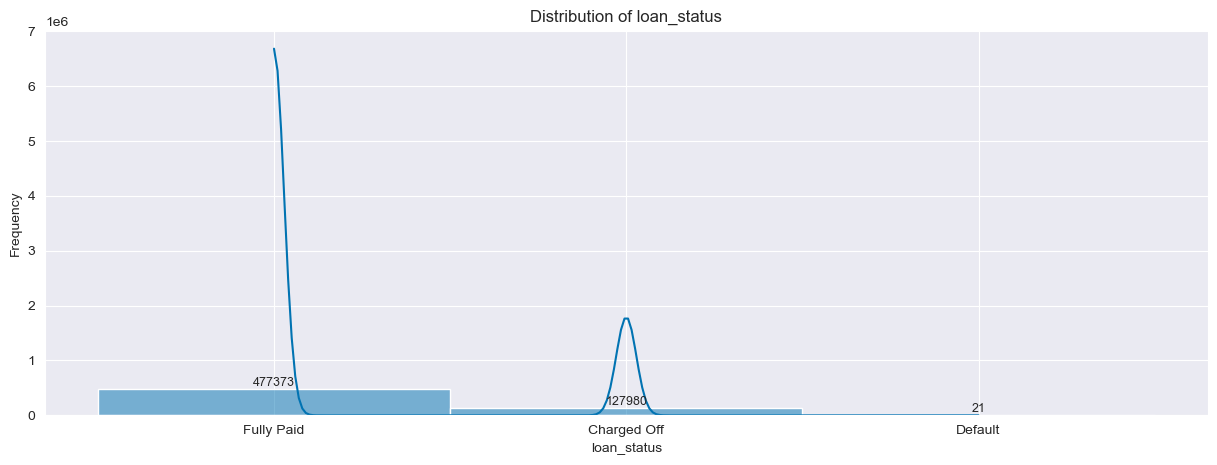

In [92]:
eda.plot_distribution("loan_status")

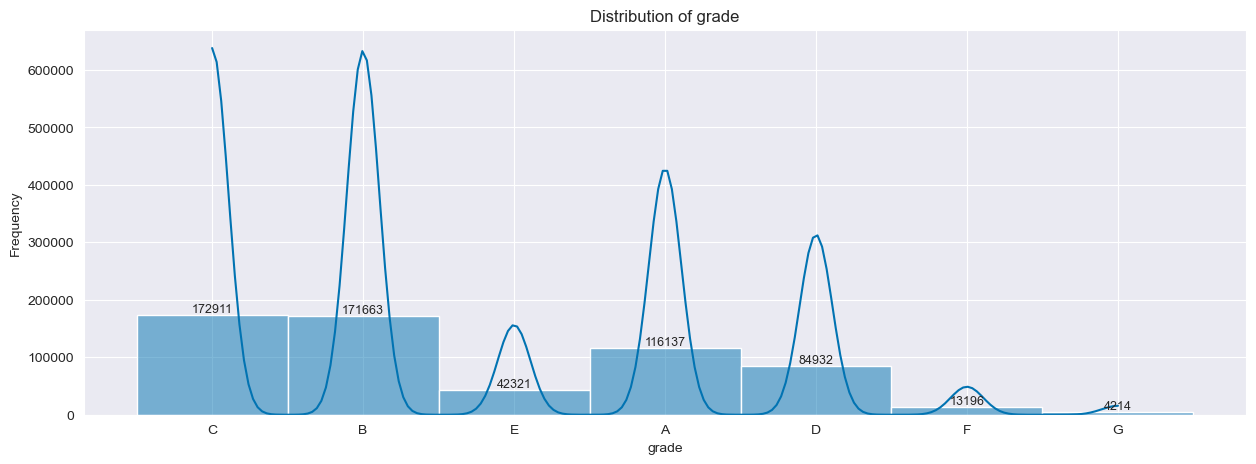

In [93]:
eda.plot_distribution("grade")

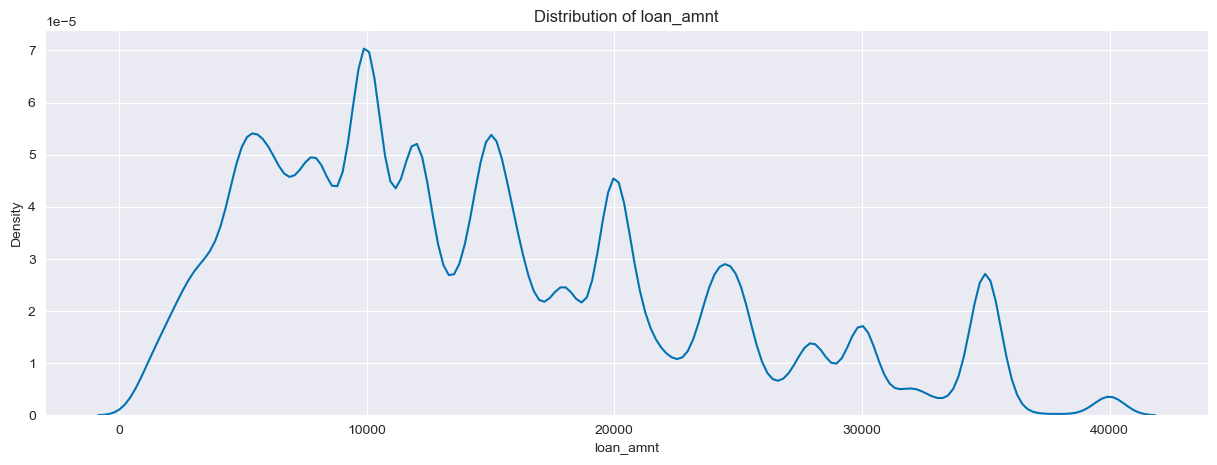

In [45]:
eda.plot_distribution("loan_amnt")

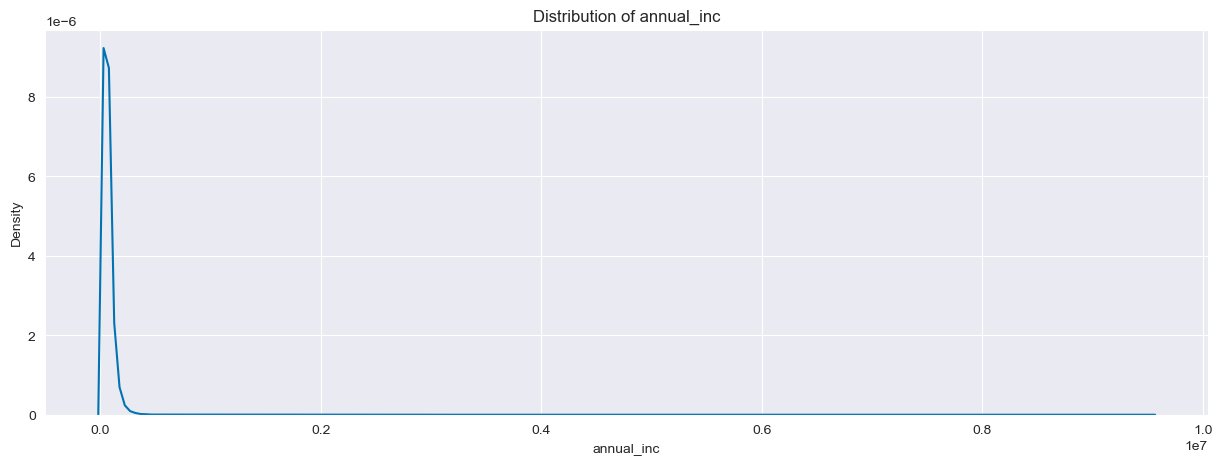

In [46]:
eda.plot_distribution("annual_inc")

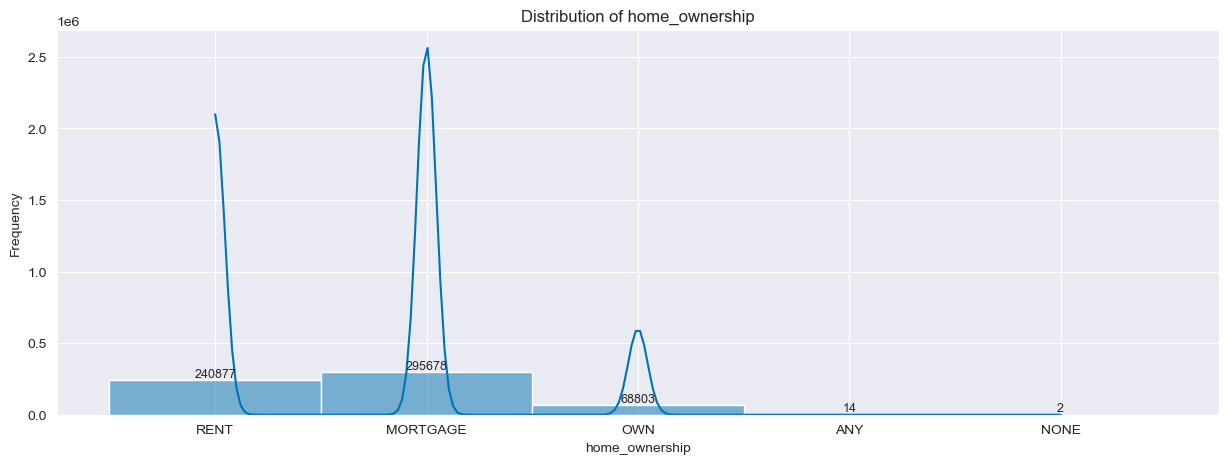

In [94]:
eda.plot_distribution("home_ownership")

### Data Relationships

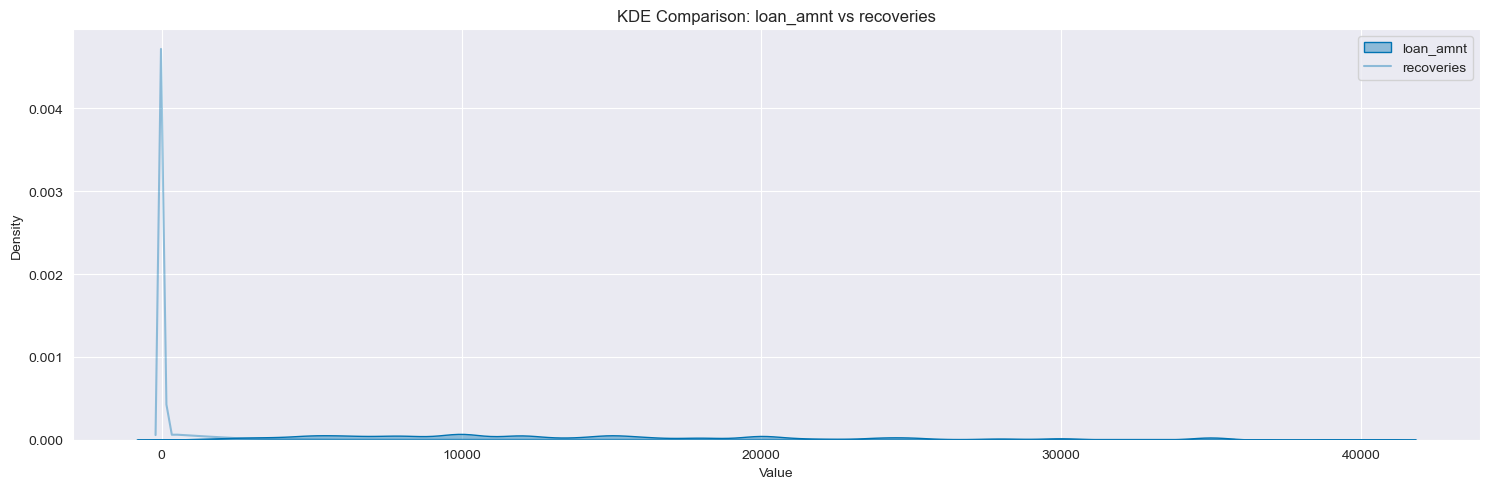

In [81]:
eda.plot_comparative_dist("loan_amnt", "recoveries", plot_type="kde")

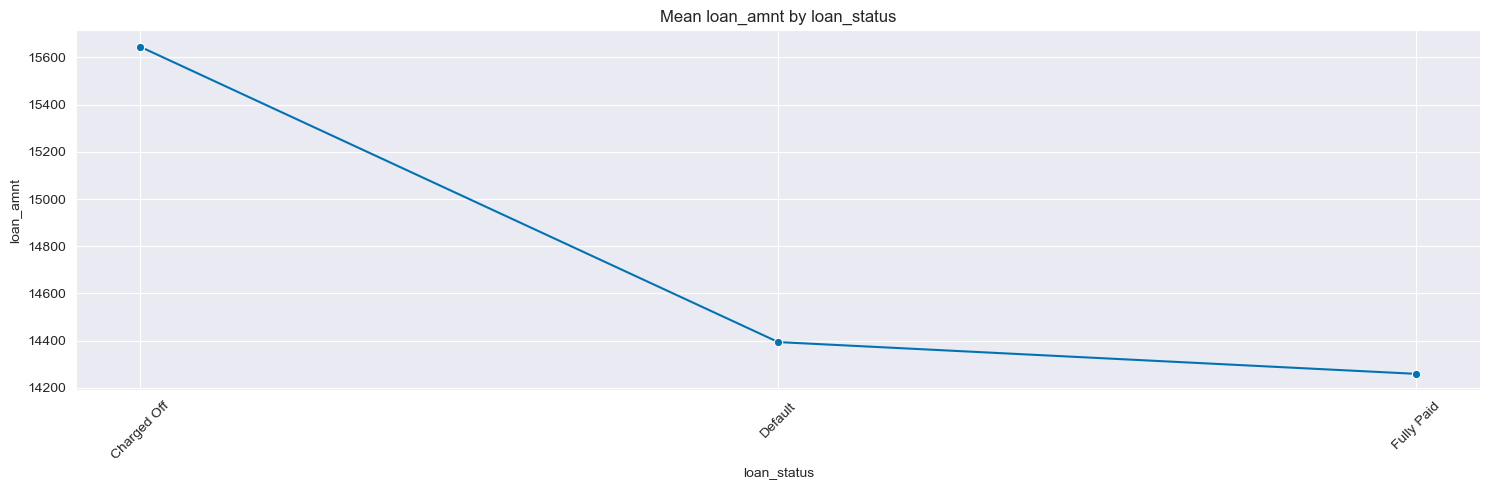

In [104]:
eda.plot_line_discrete_continuous(x_discrete="loan_status", y_continuous="loan_amnt")

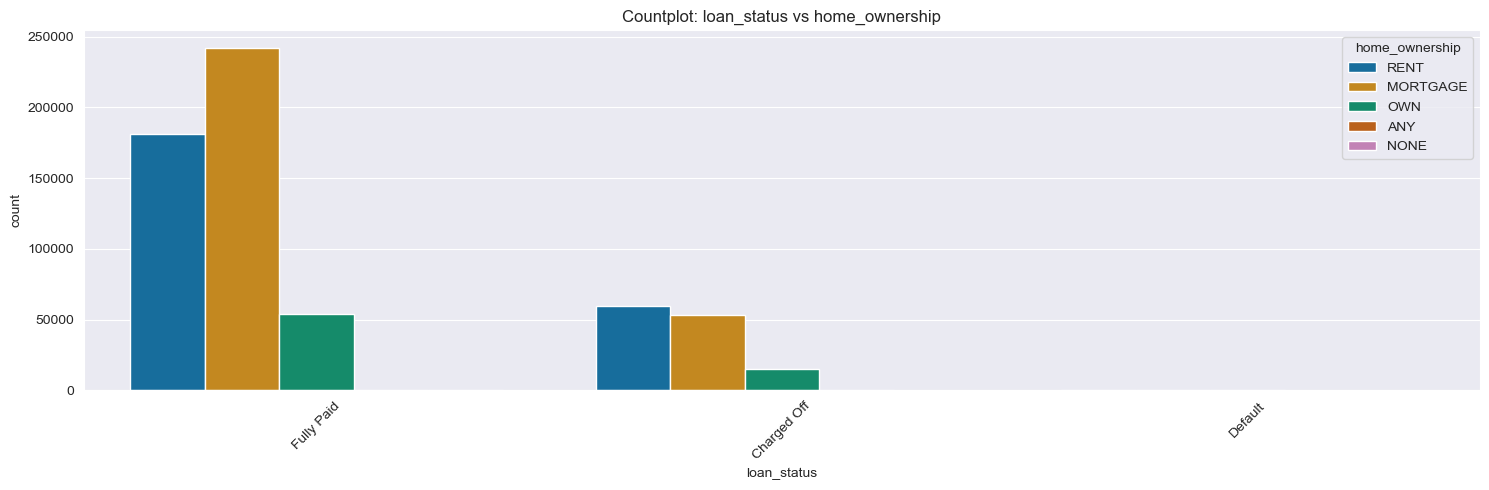

In [111]:
eda.plot_relationship_discrete("loan_status", "home_ownership")

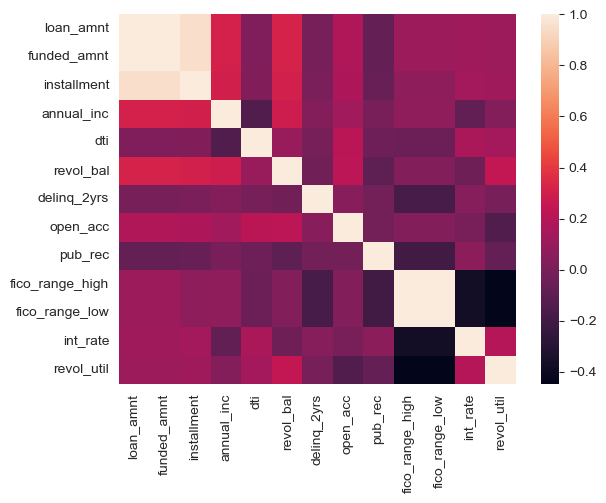

In [113]:
eda.plot_heatmap()

## 2. ANN - Model Building

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split

In [38]:
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt

In [ ]:
# DATA PREPROCESSING
df = data.copy()

# create binary target
# include charged off and default
df['binary_target'] = df['loan_status'].apply(lambda x: 1 if x in ['Default', 'Charged Off'] else 0)

# feature engineer for earliest_cr_line and issue_d
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%Y-%m')
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%Y-%m')
df['credit_history_months'] = ((df['issue_d'] - df['earliest_cr_line']) / pd.Timedelta(days=30)).astype(int)

# drop leaky / duplicate columns
df.drop(columns=['loan_status', 'id', 'issue_d', 'last_pymnt_d', 'earliest_cr_line', 'term', 'funded_amnt', 'ret_PESS', 'ret_OPT',
    'ret_INTa', 'ret_INTb', 'ret_INTc', 'total_pymnt', 'recoveries'], inplace=True)

# get lists of categorical and numerical columns
target_col = 'binary_target'
cat_cols = ['grade', 'term_num', 'emp_length', 'home_ownership', 'verification_status', 'purpose']
num_cols = [col for col in df.columns if col not in cat_cols + [target_col]]

# create dummy variables for categorical features
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# split data into features and target
x_df = df.drop(columns=[target_col])
y = df[target_col]

# split data into train and test sets
default_seed = 49  # for reproducibility
x_train, x_test, y_train, y_test = train_test_split(x_df, y, test_size=0.1, random_state=default_seed) 

# scale data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [57]:
# get number of features
n_features, n_outputs = x_train.shape[1], 1

# function for building model (with hyperparameter tuning)
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units', min_value=1, max_value=100), activation='relu', input_shape=(n_features,)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Setup EarlyStopping and ReduceLROnPlateau
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Can monitor 'val_accuracy' too
    patience=3,          # How many epochs to wait before stopping
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Can monitor 'val_accuracy' too
    factor=0.1,          # Reduce LR by this factor
    patience=2,          # How many epochs to wait before reducing LR
    min_lr=1e-6          # Lower bound for LR
)

# Use RandomSearch tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,  # number of different hyperparam combinations to try
    executions_per_trial=1,
    directory='finai-ann-default',
    project_name='tune_hidden_units_2'
)

# Search over the data
tuner.search(x_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=1, callbacks=[early_stopping, reduce_lr])

# Print the best model configuration
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best number of units: {best_hps.get('units')}")

# Get the best model from the tuner
best_model = tuner.get_best_models(num_models=1)[0]
# Evaluate on test data or make predictions
loss, accuracy = best_model.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")


Trial 15 Complete [00h 01m 18s]
val_accuracy: 0.799473226070404

Best val_accuracy So Far: 0.8005377650260925
Total elapsed time: 00h 23m 58s
Best number of units: 82
 112/1892 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.8049 - loss: 0.4160  

/Users/iman/.pyenv/versions/3.11.8/envs/ift-finai/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1892/1892 ━━━━━━━━━━━━━━━━━━━━ 1s 412us/step - accuracy: 0.7994 - loss: 0.4230
Test accuracy: 0.7993


In [58]:
# tuner summary
# tuner.results_summary()

In [59]:
history = best_model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20
13621/13621 ━━━━━━━━━━━━━━━━━━━━ 9s 597us/step - accuracy: 0.8027 - loss: 0.4230 - val_accuracy: 0.8001 - val_loss: 0.4268 - learning_rate: 0.0010
Epoch 2/20
13621/13621 ━━━━━━━━━━━━━━━━━━━━ 8s 560us/step - accuracy: 0.8019 - loss: 0.4241 - val_accuracy: 0.8000 - val_loss: 0.4273 - learning_rate: 0.0010
Epoch 3/20
13621/13621 ━━━━━━━━━━━━━━━━━━━━ 8s 562us/step - accuracy: 0.8007 - loss: 0.4242 - val_accuracy: 0.7998 - val_loss: 0.4272 - learning_rate: 0.0010
Epoch 4/20
13621/13621 ━━━━━━━━━━━━━━━━━━━━ 8s 559us/step - accuracy: 0.8021 - loss: 0.4218 - val_accuracy: 0.8003 - val_loss: 0.4249 - learning_rate: 1.0000e-04
Epoch 5/20
13621/13621 ━━━━━━━━━━━━━━━━━━━━ 8s 559us/step - accuracy: 0.8030 - loss: 0.4211 - val_accuracy: 0.8003 - val_loss: 0.4249 - learning_rate: 1.0000e-04
Epoch 6/20
13621/13621 ━━━━━━━━━━━━━━━━━━━━ 8s 559us/step - accuracy: 0.8018 - loss: 0.4221 - val_accuracy: 0.8002 - val_loss: 0.4250 - learning_rate: 1.0000e-04
Epoch 7/20
13621/13621 ━━━━━━━━━━━━━━━━━

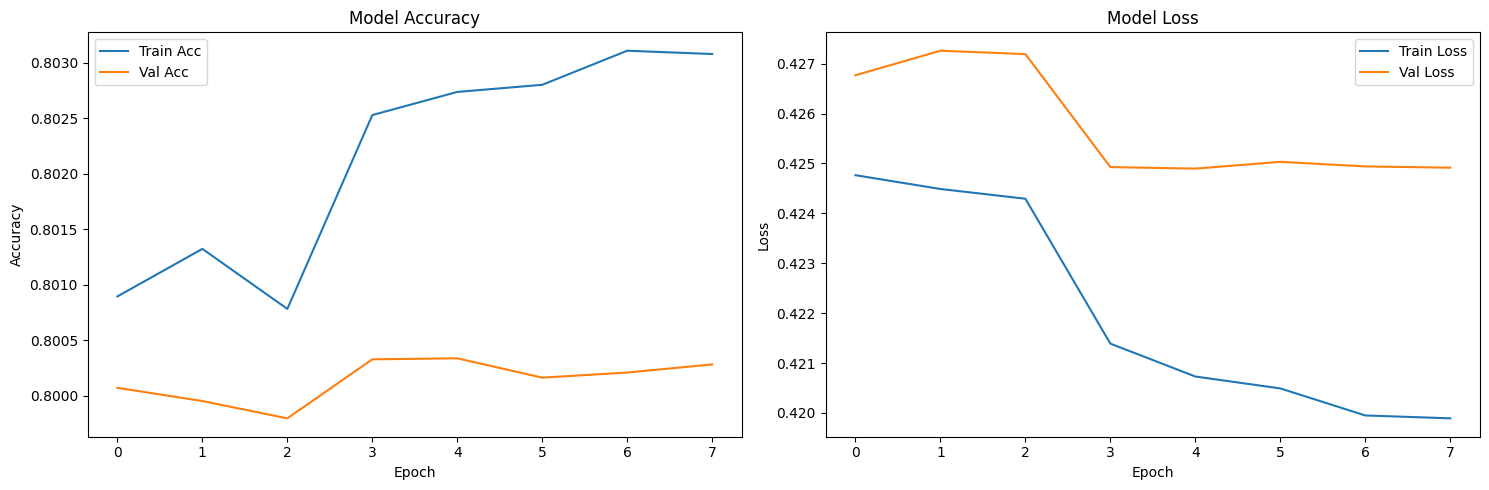

In [60]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [64]:
best_model.save('models/default-binary-exp-2/model.keras')

# Save model architecture as JSON
model_json = best_model.to_json()
with open("models/default-binary-exp-2/model-architecture.json", "w") as json_file:
    json_file.write(model_json)

# save tuner
tuner.save()

# save scaler
import joblib
joblib.dump(scaler, 'models/default-binary-exp-2/scaler.pkl')


['models/default-binary-exp-2/scaler.pkl']

### Result Analysis